In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
varinfo.clear()

In [4]:
module = fc.eightb.preselection.t8btag_minmass
dout = 't8btag_minmass'

In [5]:
# data = ObjIter([Tree(module.JetHT_Data_UL_List)])
signal = ObjIter([ Tree(f) for f in module.signal_list ])
bkg = ObjIter([ Tree(module.QCD_B_List), Tree(module.TTJets)])

100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


In [6]:
(signal+bkg).apply(lambda t : build_collection(t, 'H\dY\d_b\d', 'jet', ordered='ptRegressed'))

[None, None, None, None, None]

In [7]:
signal = signal.apply(eightb.selected_jet_ptregressed())
bkg = bkg.apply(eightb.selected_jet_ptregressed())

In [8]:
signal = signal.apply(eightb.selected_jet_btagwp())
bkg = bkg.apply(eightb.selected_jet_btagwp())

In [9]:
bkg.reweight(2.3)
bkg.set_systematics(0.2)

[None, None]

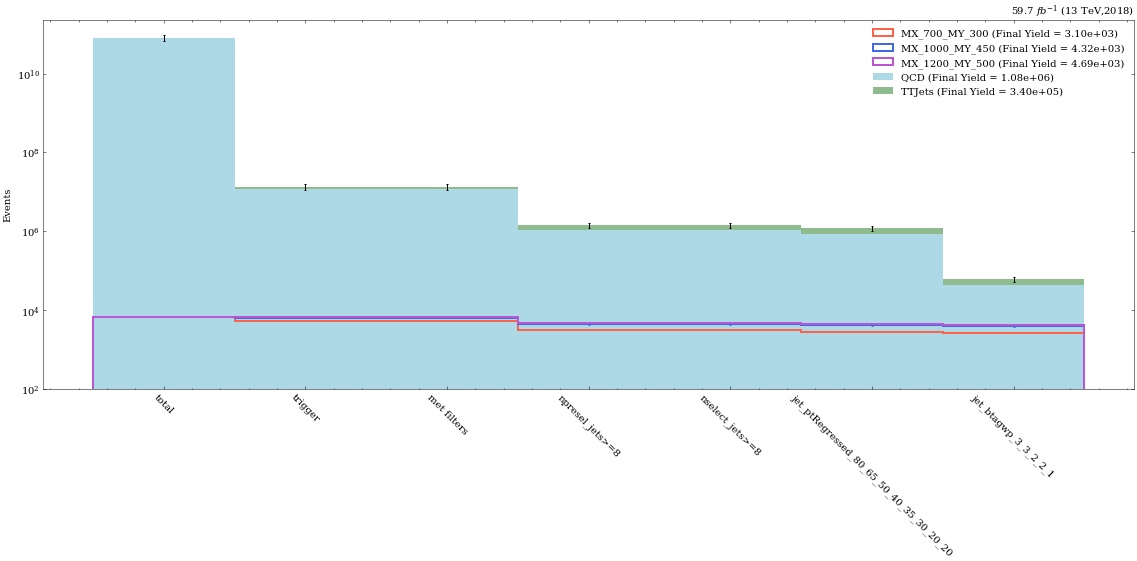

In [10]:
def get_efficiency(histo):
    print(histo)
    return 

study.cutflow(
    signal+bkg, legend=True, legend_loc="upper right",
    h_label_stat="Final Yield = {histo[4]:0.2e}",
    ylim=(1e2, -1), log=True,
    saveas="cutflow"
)

In [11]:
from collections import defaultdict
def get_sample_yields(t):
    lumi,_ = lumiMap[2018]
    class _sample:
        def __init__(self):
            self.yields = 0
            self.xsec = 0
    samples = defaultdict(_sample)
    for i, f in enumerate(t.filelist):
        mask = t.sample_id==i
        yields = ak.sum(t.scale[mask])*lumi

        samples[f.sample].yields += yields
        samples[f.sample].xsec = f.xsec

    for name, sample in samples.items():
        print(f'{name}, {sample.xsec}, {sample.yields}')
(signal+bkg).apply(get_sample_yields)

NMSSM_XYY_YToHH_8b, 0.11504969328885763, 2650.4986749459363
NMSSM_XYY_YToHH_8b, 0.11504969328885763, 3893.152125833527
NMSSM_XYY_YToHH_8b, 0.11504969328885763, 4307.960688690021
QCD_bEnriched_HT100to200, 1127000.0, 0.0
QCD_bEnriched_HT200to300, 80430.0, 598.5880576209184
QCD_bEnriched_HT300to500, 16620.0, 17742.45224876989
QCD_bEnriched_HT500to700, 1487.0, 16859.026514837733
QCD_bEnriched_HT700to1000, 296.5, 9300.36669874984
QCD_bEnriched_HT1000to1500, 46.61, 3253.093884127864
QCD_bEnriched_HT1500to2000, 3.72, 462.8329634292725
QCD_bEnriched_HT2000toInf, 0.6462, 105.9058935498558
QCD_HT200to300_BGenFilter, 111700.0, 1950.5481627512515
QCD_HT300to500_BGenFilter, 27960.0, 12714.98490693891
QCD_HT500to700_BGenFilter, 3078.0, 18853.965580273754
QCD_HT700to1000_BGenFilter, 721.8, 13870.68936683414
QCD_HT1000to1500_BGenFilter, 138.2, 5130.66075948032
QCD_HT1500to2000_BGenFilter, 13.61, 973.4540661838681
QCD_HT2000toInf_BGenFilter, 2.92, 365.4970982306346
TTJets, 831.76, 36331.914827465516


[None, None, None, None, None]

100%|██████████| 1/1 [00:03<00:00,  3.16s/it]


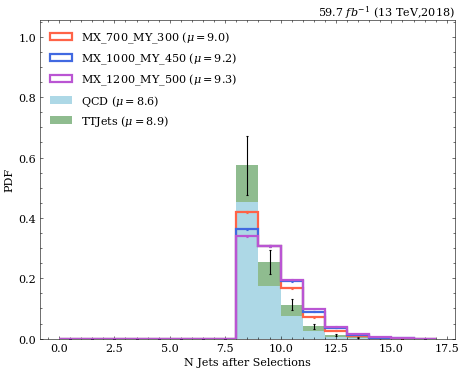

In [12]:
study.quick(
    signal+bkg, legend=True, h_label_stat='mean',
    efficiency=True,
    varlist=['n_jet'],
    xlabels=['N Jets after Selections'],
    saveas=f'{dout}/n_presel_jets'
)

100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


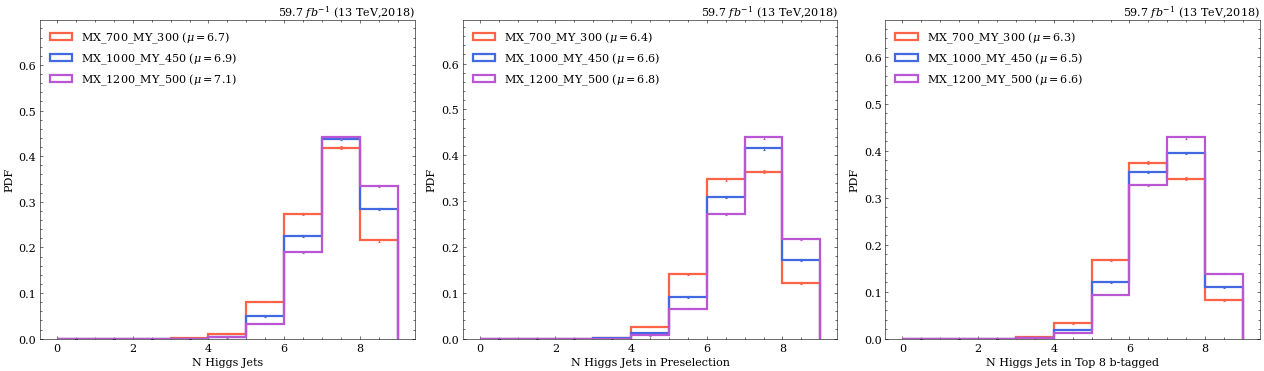

In [13]:
study.quick(
    signal, legend=True, h_label_stat='mean',
    efficiency=True,
    varlist=['nfound_all','nfound_presel','nfound_select'],
    xlabels=['N Higgs Jets','N Higgs Jets in Preselection','N Higgs Jets in Top 8 b-tagged'],
    dim=-1,
    saveas=f'{dout}/n_higgs_jets'
)

In [14]:
njets_lost = lambda t:t.nfound_presel-t.nfound_select

def frac_events(t):
    nlost = njets_lost(t)
    return f"{ak.mean(nlost>0):0.2%}"

signal.apply(frac_events)

['13.83%', '17.28%', '18.93%']

100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


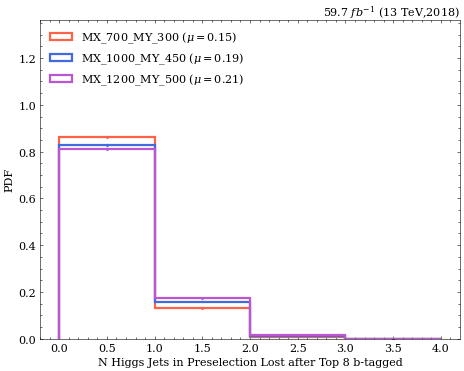

In [15]:
study.quick(
    signal, legend=True, h_label_stat='mean',
    varlist=[njets_lost],
    xlabels=['N Higgs Jets in Preselection Lost after Top 8 b-tagged'],
    dim=-1,
    efficiency=True,
    saveas=f'{dout}/n_higgs_jets_lost'
)

100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


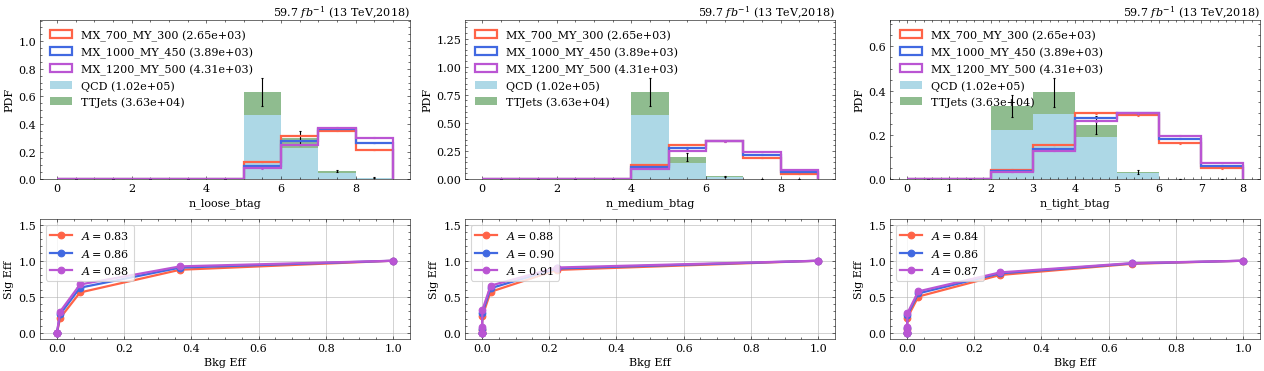

In [33]:
study.quick(
    bkg+signal, legend=True,
    # masks=lambda t:t.n_loose_btag==8,
    varlist=['n_loose_btag','n_medium_btag','n_tight_btag'],
    efficiency=True, dim=-1,
    **study.auroc,

    saveas=f'{dout}/btag_multi'
)

In [17]:

(signal+bkg).apply(lambda t : build_collection(t, 'H\dY\d', 'higgs', ordered='pt'))

[None, None, None, None, None]

100%|██████████| 4/4 [00:03<00:00,  1.29it/s]


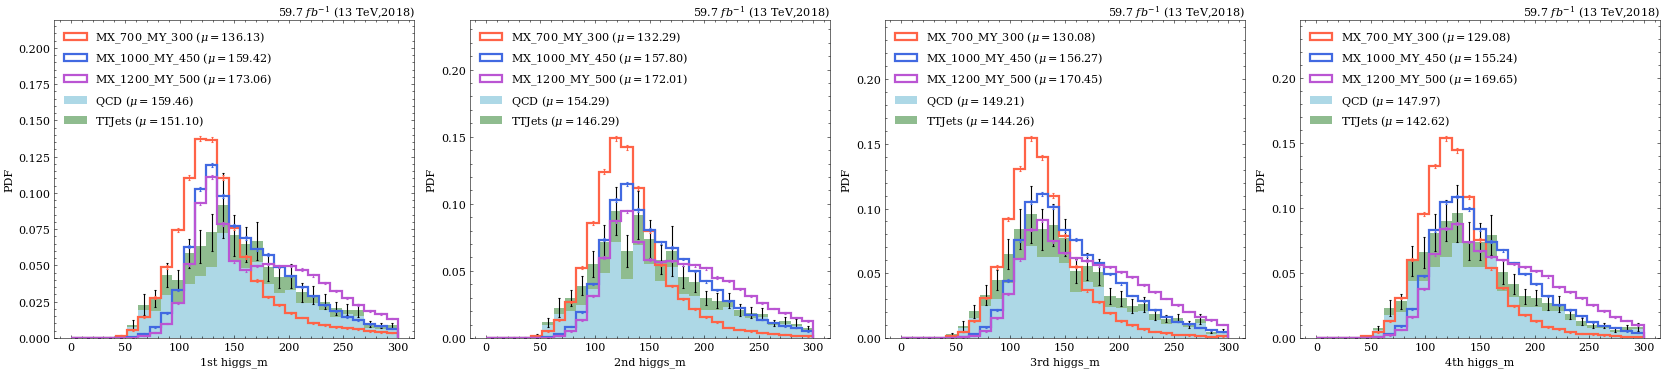

In [18]:
study.quick(
    signal+bkg,
    legend=True, h_label_stat='$\mu={stats.mean:0.2f}$',
    varlist=[f'higgs_m[:,{i}]' for i in range(4)],
    binlist=[(0,300,30)]*4,
    dim=-1,
    efficiency=True,
    saveas=f'{dout}/higgs_m'
)

In [19]:
varinfo.jet_btag = dict(bins=(0,1,30))

100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


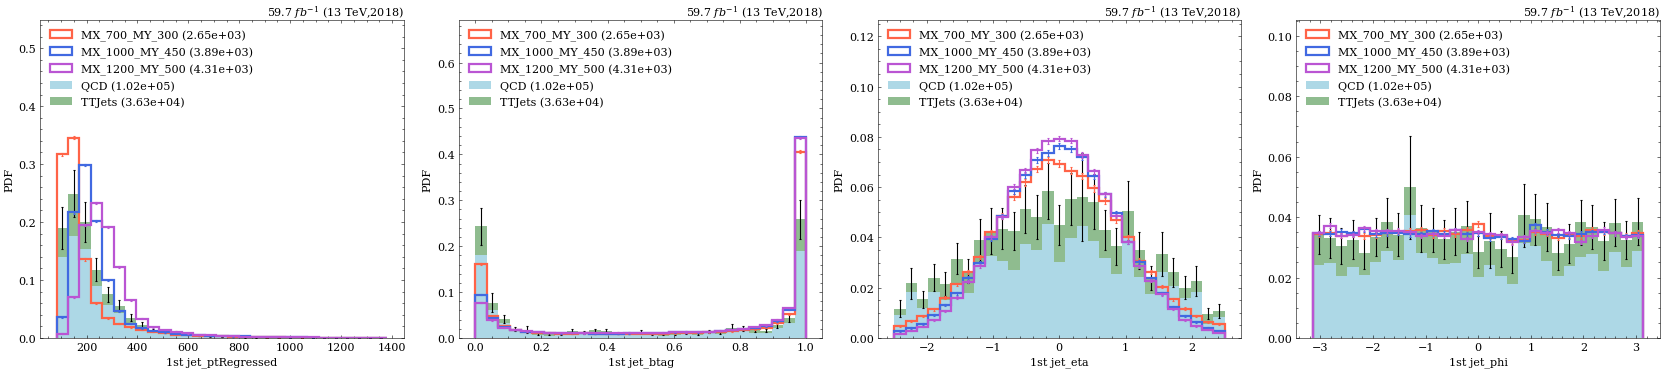

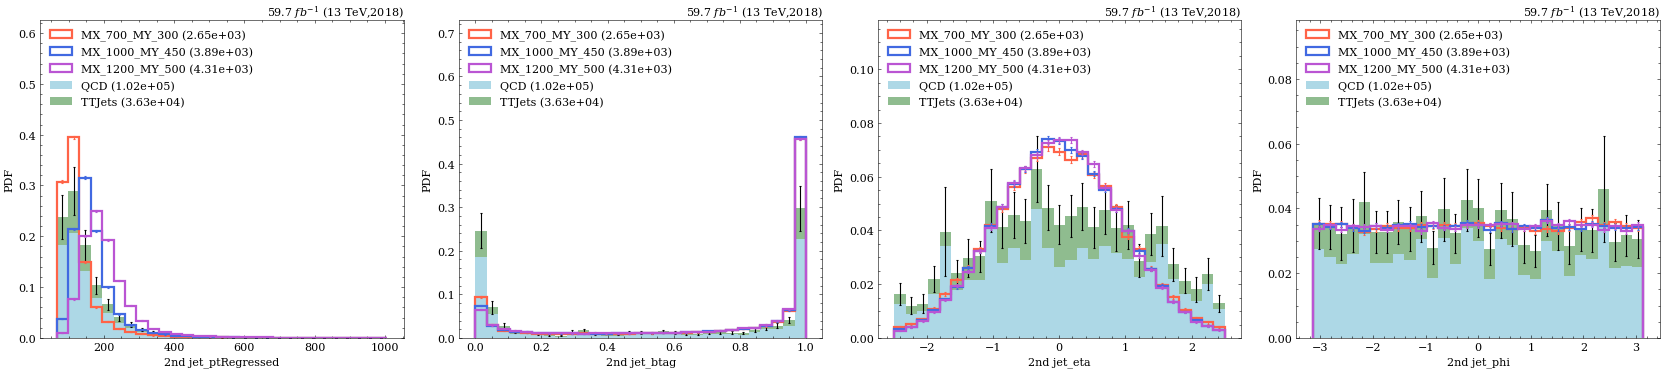

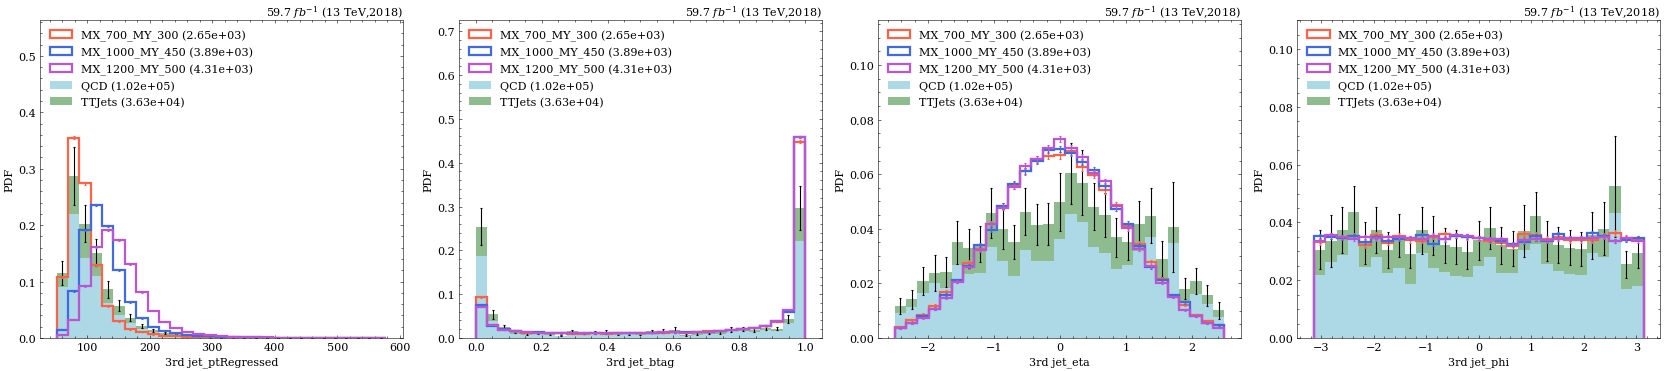

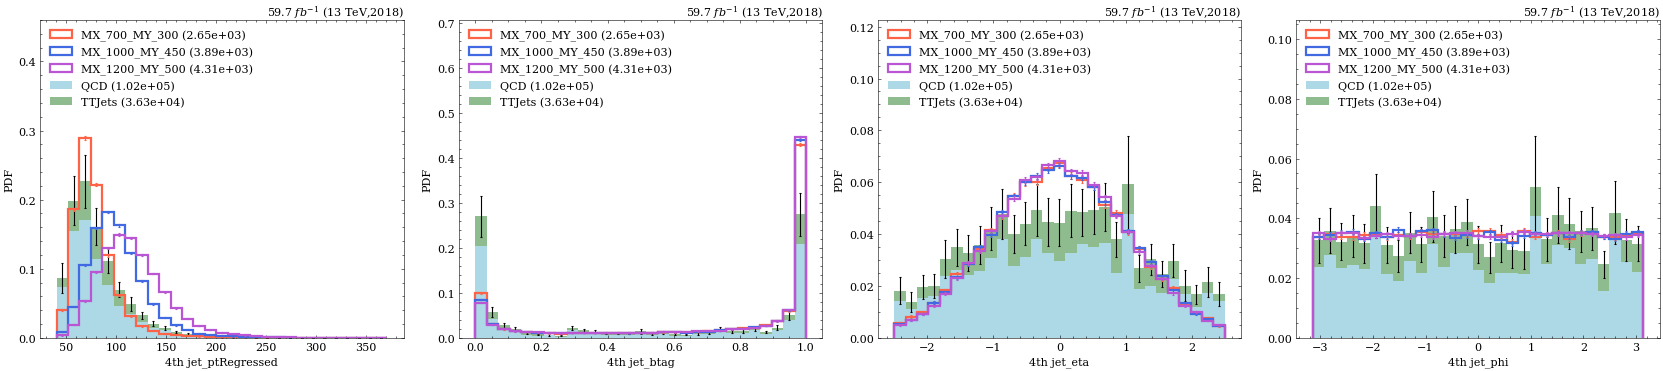

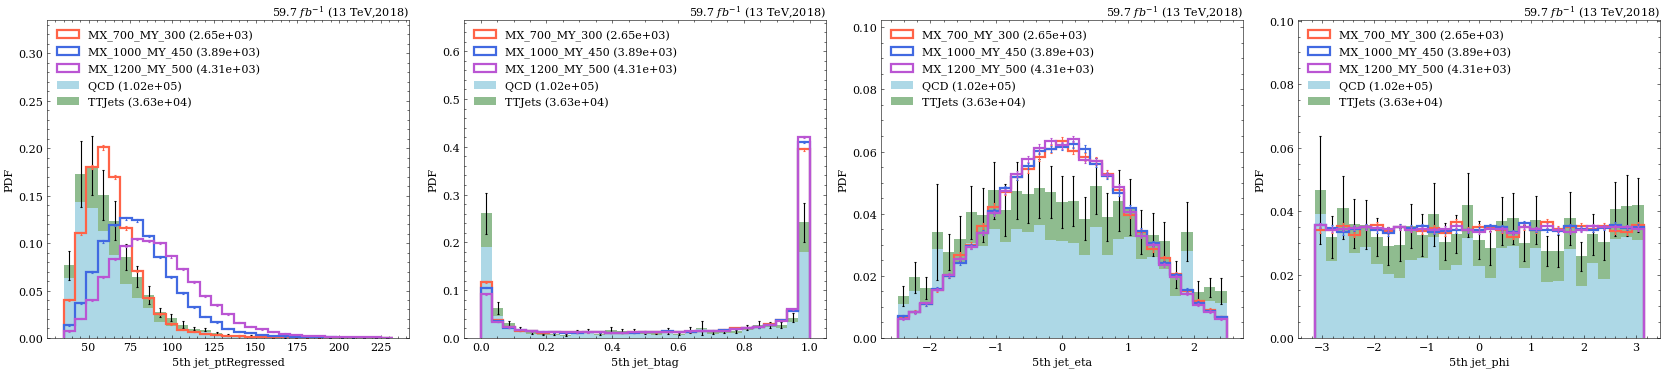

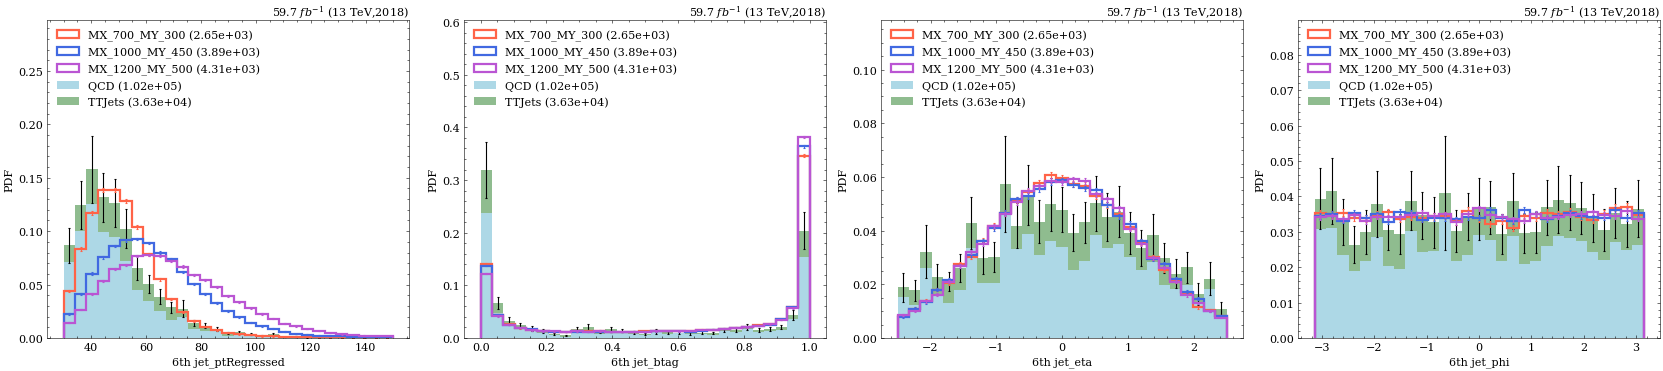

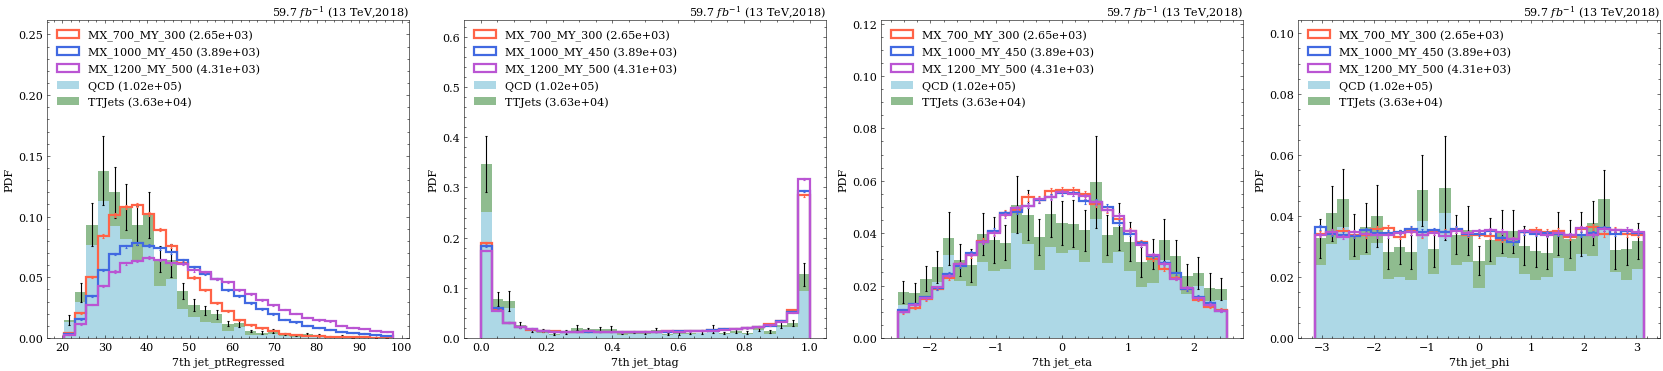

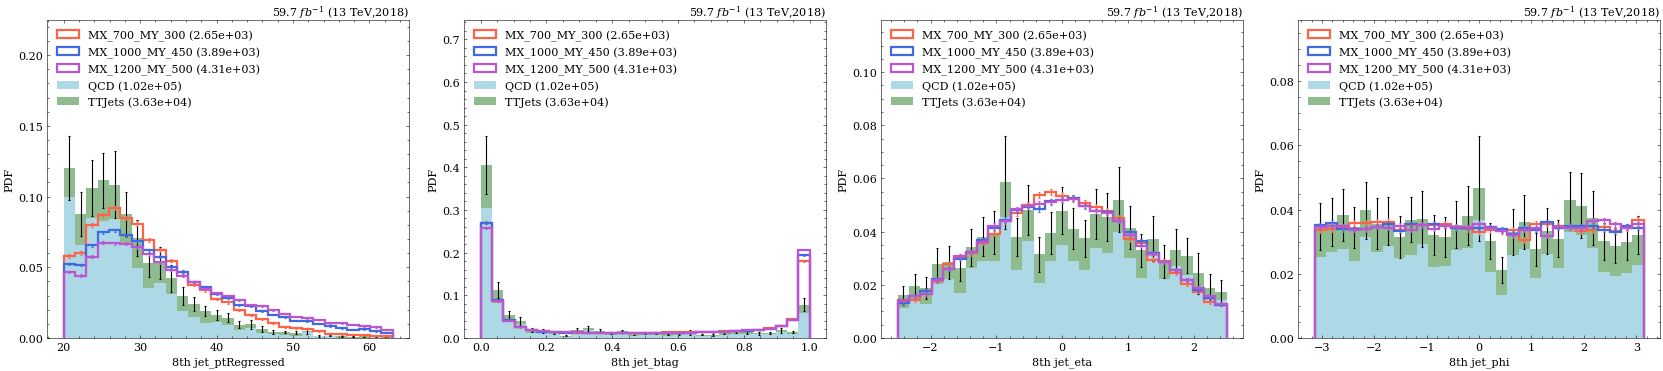

In [20]:
for i in range(8):
    study.quick( 
        signal+bkg, legend=True, 
        varlist=[f'jet_{var}[:,{i}]' for var in ('ptRegressed','btag','eta','phi')],
        efficiency=True,
        dim=-1,
        saveas=f'{dout}/{ordinal(i)}_pt_jet'
    )

In [21]:
varinfo.higgs_m = dict(bins=(0,500,30))

100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


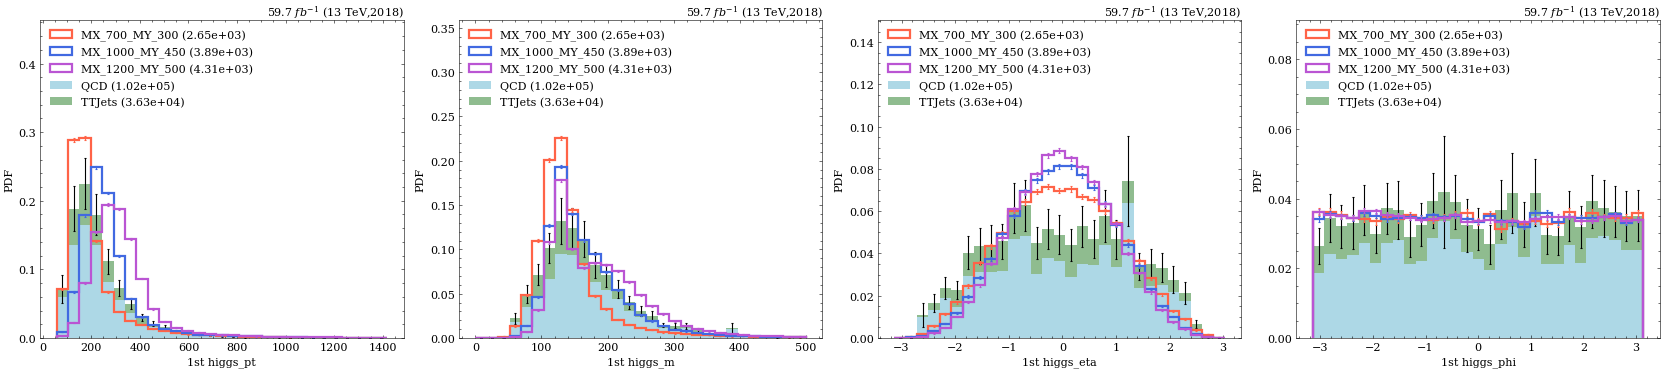

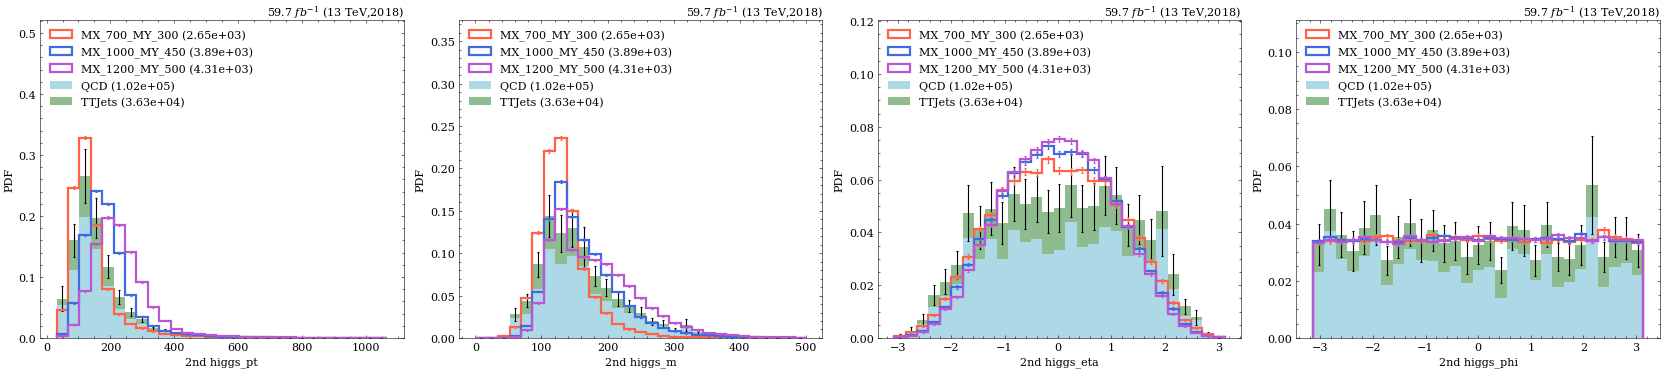

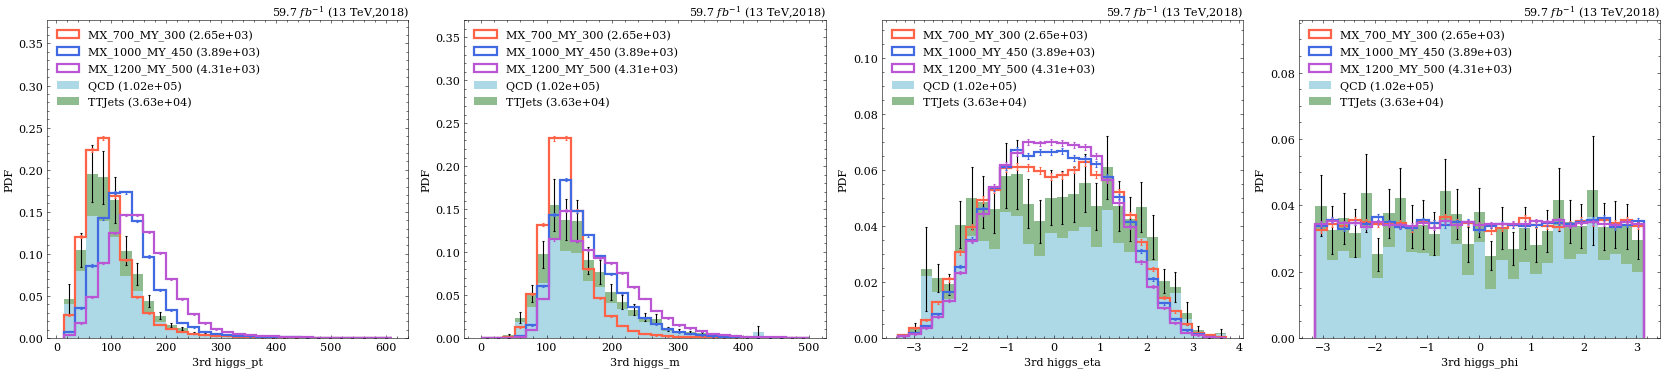

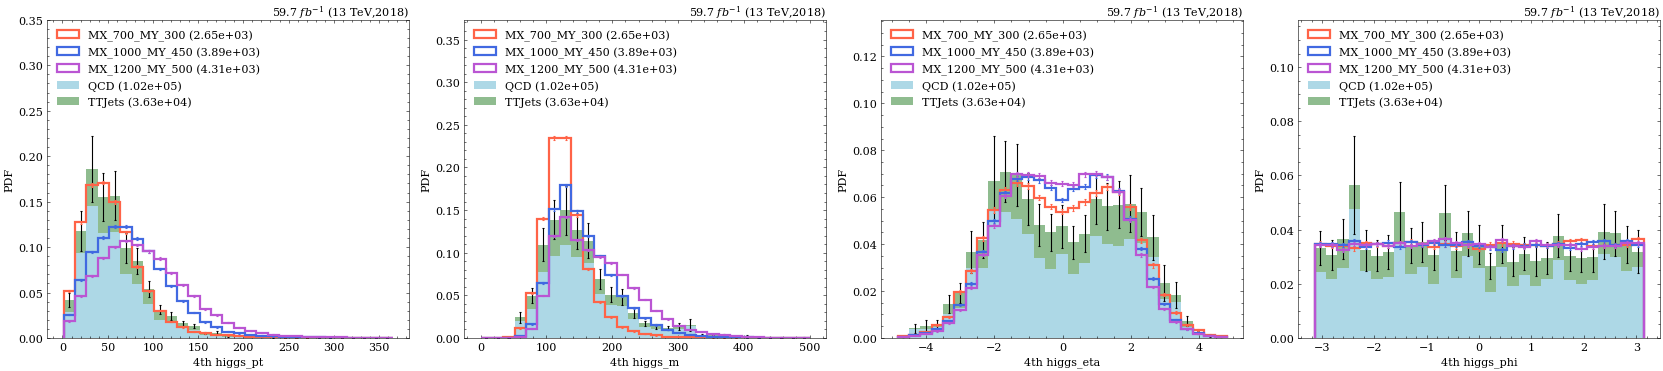

In [22]:
for i in range(4):
    study.quick( 
        signal+bkg, legend=True, efficiency=True,
        varlist=[f'higgs_{var}[:,{i}]' for var in ('pt','m','eta','phi')],
        dim=-1,
        saveas=f'{ordinal(i)}_pt_higgs'
    )

In [23]:
varinfo.Y1_m = dict(bins=(0,1000,30))
varinfo.Y2_m = dict(bins=(0,1000,30))


100%|██████████| 4/4 [00:03<00:00,  1.33it/s]


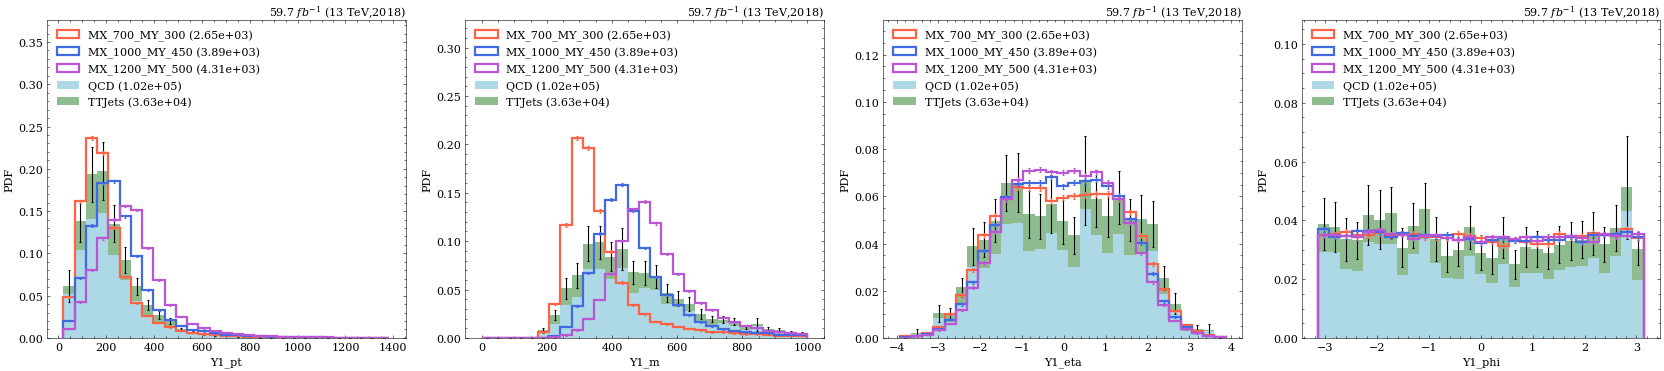

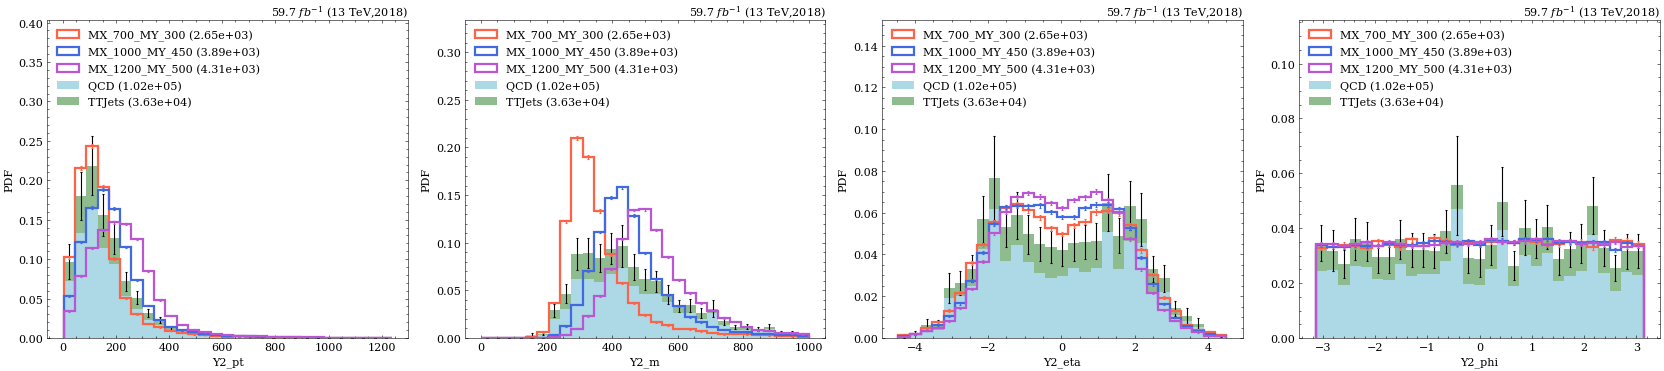

In [24]:
for i in range(2):
    study.quick( 
        signal+bkg, legend=True, efficiency=True,
        varlist=[f'Y{i+1}_{var}' for var in ('pt','m','eta','phi')],
        dim=-1,
        saveas=f'{dout}/{ordinal(i)}_pt_y'
    )

In [25]:
varinfo.X_m = dict(bins=(500,2000,30))

100%|██████████| 4/4 [00:08<00:00,  2.03s/it]


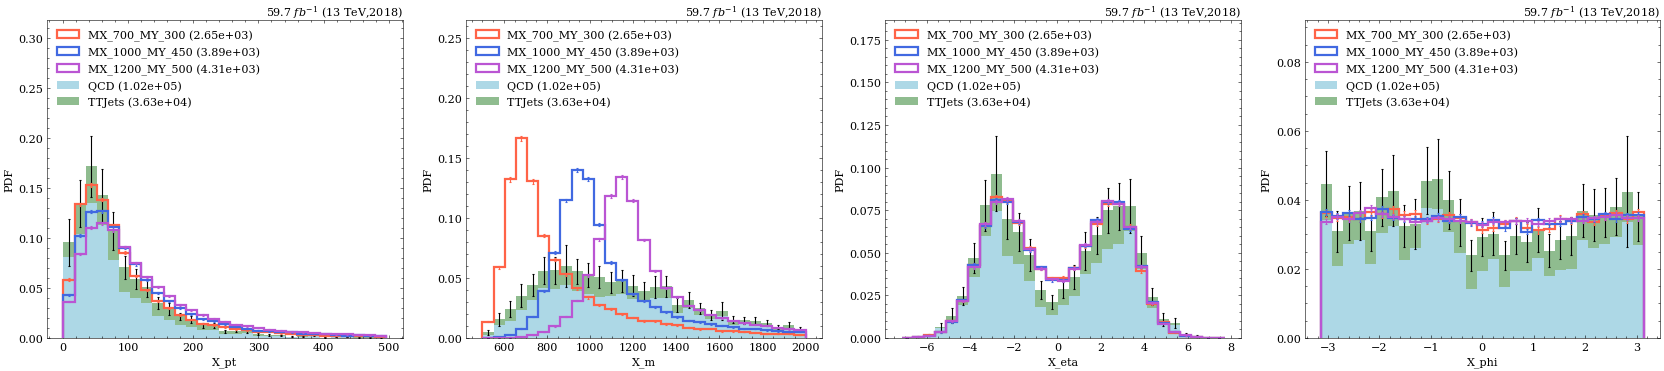

In [26]:
study.quick( 
    signal+bkg, legend=True, efficiency=True,
    varlist=[f'X_{var}' for var in ('pt','m','eta','phi')],
    dim=-1,
    saveas=f'{dout}/X'
)

100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


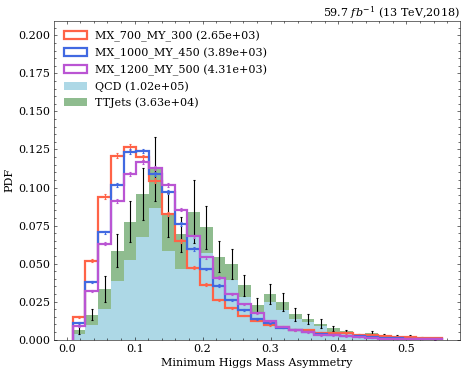

In [27]:
def hm_asym(t):
    hm = np.abs(t.higgs_m)
    hm_max, hm_min = ak.max(hm, axis=-1), ak.min(hm, axis=-1)
    asym = (hm_max-hm_min)/(hm_max+hm_min)
    t.extend(hm_asym=asym)
    return asym

study.quick(
    signal+bkg, 
    legend=True,
    # efficiency=True, 
    efficiency=True,
    varlist=[hm_asym],
    xlabels=['Minimum Higgs Mass Asymmetry'],
    saveas=f'{dout}/hm_asym',
)

100%|██████████| 1/1 [00:02<00:00,  2.88s/it]


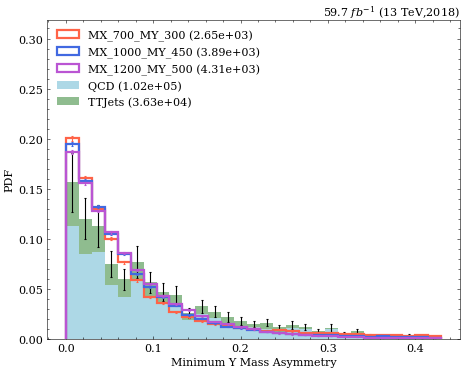

In [28]:
def ym_asym(t):
    ym = ak_stack([t.Y1_m, t.Y2_m])
    ym_max, ym_min = ak.max(ym, axis=-1), ak.min(ym, axis=-1)
    asym = (ym_max-ym_min)/(ym_max+ym_min)
    t.extend(ym_asym=asym)
    return asym

study.quick(
    signal+bkg, 
    legend=True,
    # efficiency=True, 
    efficiency=True,
    varlist=[ym_asym],
    xlabels=['Minimum Y Mass Asymmetry'],
    saveas=f'{dout}/ym_asym',
)

100%|██████████| 1/1 [00:22<00:00, 22.39s/it]


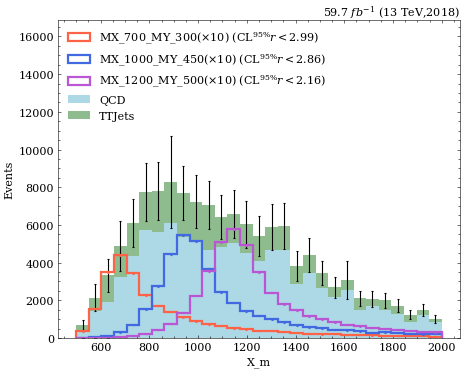

In [31]:
study.quick(
    signal+bkg, legend=True,
    # scale=[100]*len(signal),
    plot_scale=[10]*len(signal),
    varlist=['X_m'],
    limits=True,
    saveas=f'{dout}/limits/no_cuts'
)

100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


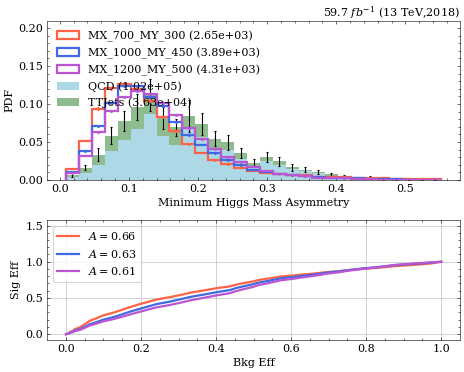

In [34]:
study.quick(
    signal+bkg, 
    legend=True,
    # efficiency=True, 
    efficiency=True,
    varlist=[hm_asym],
    xlabels=['Minimum Higgs Mass Asymmetry'],

    **study.auroc,
    saveas=f'{dout}/hm_asym_roc',
)

100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


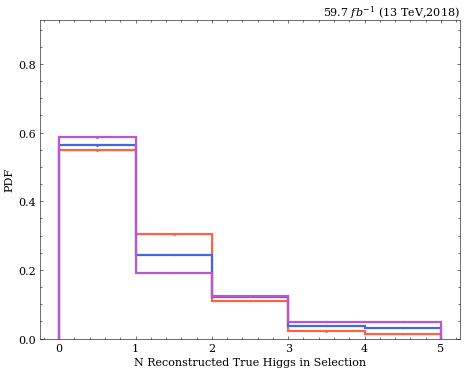

In [35]:
study.quick(
    signal,
    varlist=['nfound_paired_h'],
    efficiency=True,
    xlabels=['N Reconstructed True Higgs in Selection']
)

100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


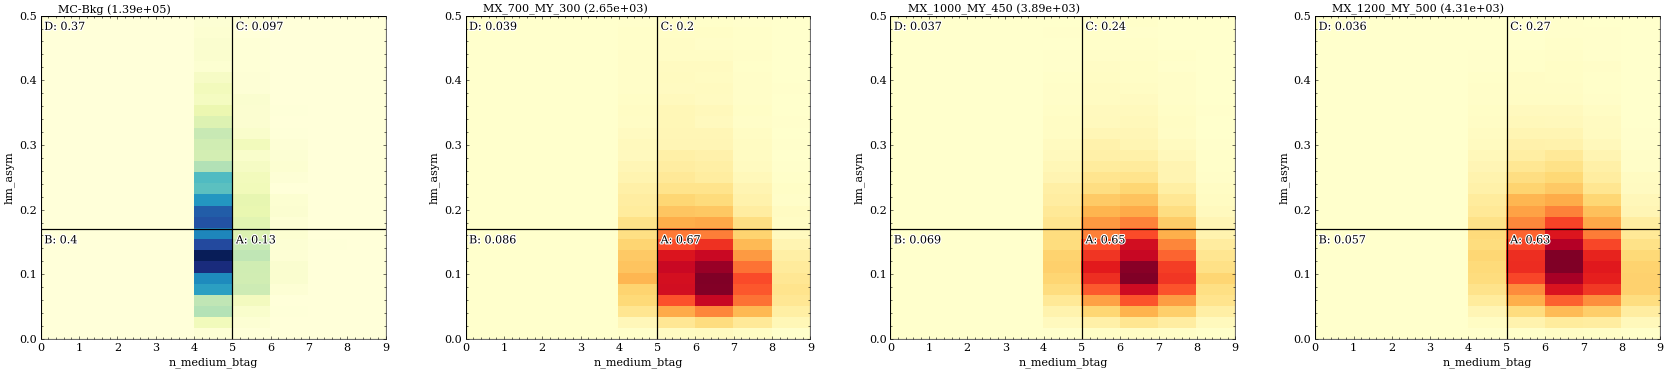

In [39]:
study.quick2d(
    signal+bkg,
    varlist=['n_medium_btag','hm_asym'],
    binlist=[None, (0,0.5,30)],
    exe=draw_abcd(x_r=(0,5,9),y_r=(0,0.17,0.5), regions=["C","D","A","B"]),
    saveas=f'{dout}/limits/abcd_loose_btag_vs_hm_asym'
)

In [40]:
bdt = ABCD(
    features=['X_m','X_pt'],
    a = lambda t : (t.n_medium_btag >= 5) &                         (t.hm_asym < 0.17),
    b = lambda t : (t.n_medium_btag >= 2) & (t.n_medium_btag < 5) & (t.hm_asym < 0.17),
    c = lambda t : (t.n_medium_btag >= 5) &                         (t.hm_asym > 0.17),
    d = lambda t : (t.n_medium_btag >= 2) & (t.n_medium_btag < 5) & (t.hm_asym > 0.17),
)

100%|██████████| 1/1 [00:21<00:00, 21.54s/it]


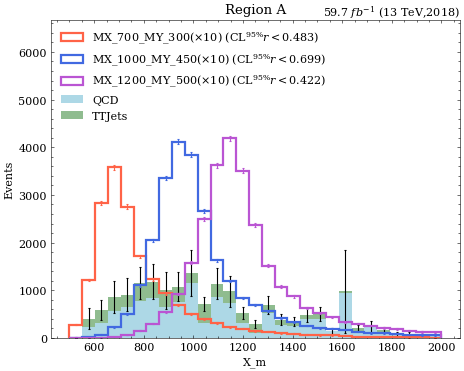

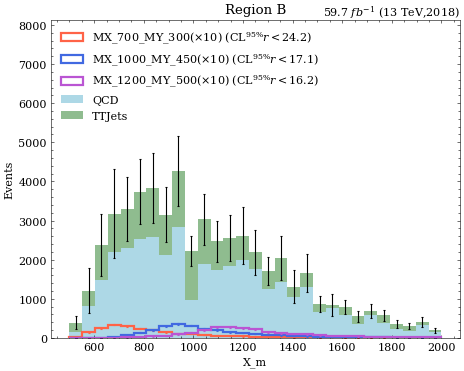

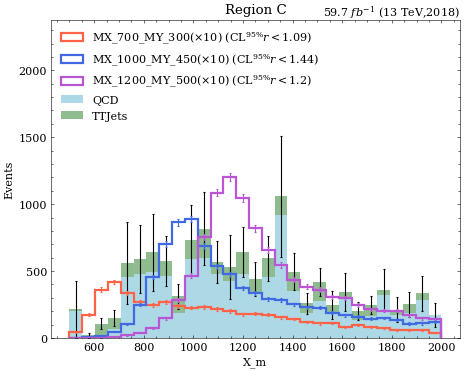

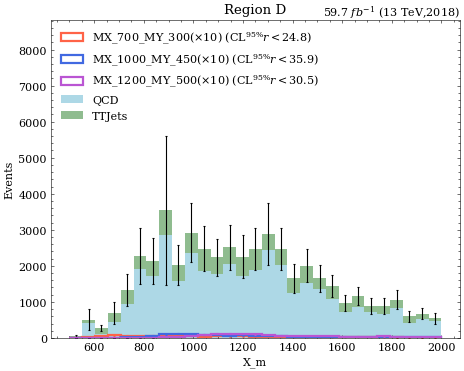

In [41]:
for r in ('a','b','c','d'):
    study.quick(
        signal + bkg, 
        legend=True,
        plot_scale=[10]*len(signal),
        masks=getattr(bdt,r),
        varlist=['X_m'],
        limits=True,
        title=f'Region {r.upper()}',
        saveas=f'{dout}/limits/region_{r}'
    )

In [42]:
bdt.train(bkg)
bdt.print_results(bkg)

--- ABCD Results ---
k = 2.603e-01
k*(b/a)-1  = -16.88%
BDT(b)/a-1 = -17.10%



100%|██████████| 2/2 [00:05<00:00,  2.89s/it]


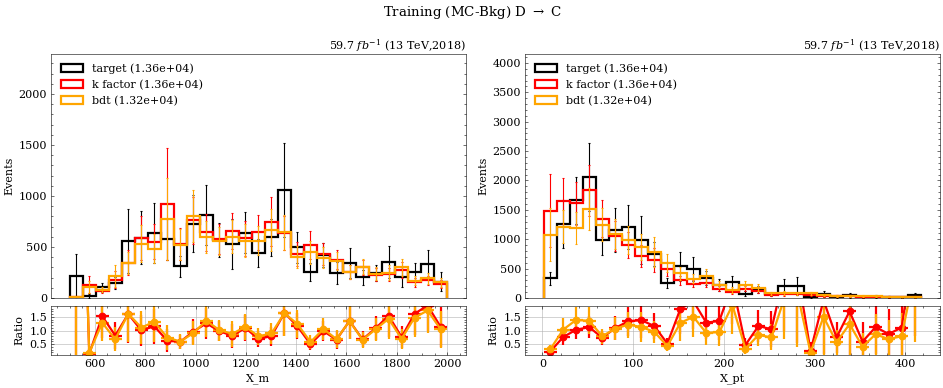

In [43]:
study.quick_region(
    bkg, bkg, bkg, label=['target','k factor','bdt'],
    h_color=['black','red','orange'], legend=True,
    masks=[bdt.c]*len(bkg)+[bdt.d]*(len(bkg)*2),
    scale=[1]*len(bkg)+[bdt.scale_tree]*len(bkg)+[bdt.reweight_tree]*len(bkg),
    varlist=bdt.feature_names,
    suptitle='Training (MC-Bkg) D $\\rightarrow$ C',
    ratio=True,
    saveas=f'{dout}/bdt/training'
)

100%|██████████| 2/2 [00:05<00:00,  2.91s/it]


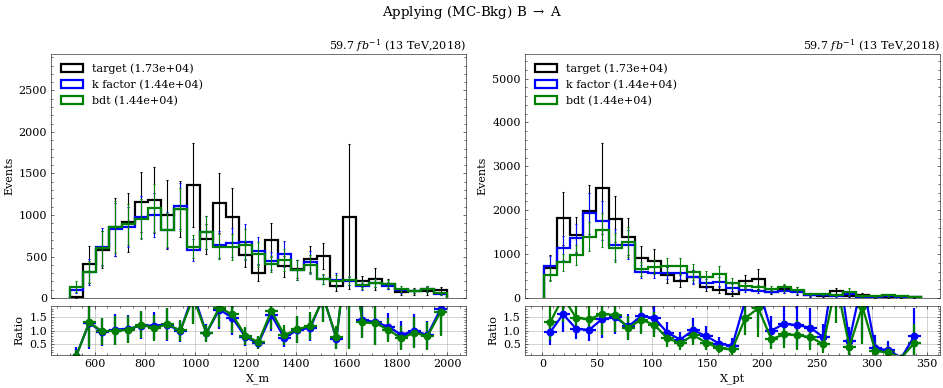

In [44]:
study.quick_region(
    bkg, bkg, bkg, label=['target','k factor','bdt'],
    h_color=['black','blue','green'], legend=True,
    masks=[bdt.a]*len(bkg)+[bdt.b]*(len(bkg)*2),
    scale=[1]*len(bkg)+[bdt.scale_tree]*len(bkg)+[bdt.reweight_tree]*len(bkg),
    varlist=bdt.feature_names,
    suptitle='Applying (MC-Bkg) B $\\rightarrow$ A',
    saveas=f'{dout}/bdt/applying',
    ratio=True,
)

100%|██████████| 1/1 [00:22<00:00, 22.32s/it]


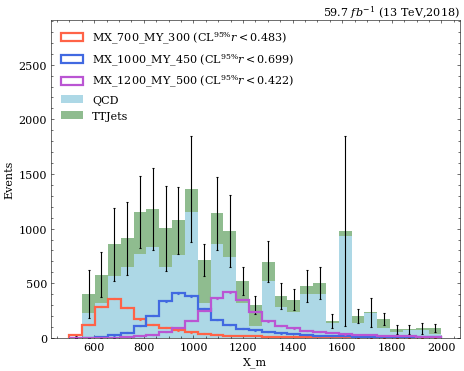

In [47]:
study.quick(
    signal + bkg, 
    legend=True,
    # plot_scale=[10]*len(signal),
    masks=bdt.a,
    varlist=['X_m'],
    limits=True,
)

100%|██████████| 1/1 [00:20<00:00, 20.76s/it]


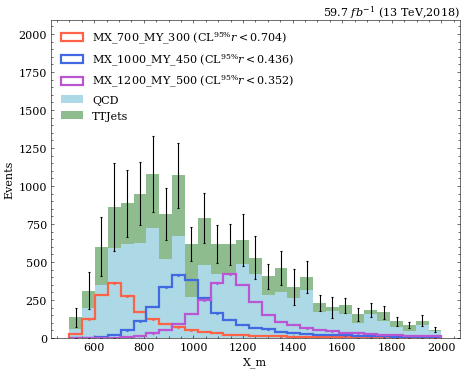

In [48]:
study.quick(
    signal + bkg, 
    legend=True,
    # plot_scale=[10]*len(signal),
    masks=[bdt.a]*len(signal)+[bdt.b]*(len(bkg)*2),
    scale=[1]*len(signal)+[bdt.reweight_tree]*len(bkg),
    varlist=['X_m'],
    limits=True,
    saveas=f'{dout}/limits/bdt_bkg_model'
)